Andy Tzanidakis\
Dec. 13th
LSDB **main**, TAPE **main**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb

In [2]:
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [2]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

## Cone Search

In [33]:
%%time
ra, dec = 32, 5
rad = 5 # in degrees
_sample = gaia.cone_search(
    ra=ra,
    dec=dec,
    radius=rad,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 150 and nobs_r_ztf_dr14 > 150 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 10 and \
    classprob_dsc_combmod_star_gaia > 0.9"
).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 17.8 s, sys: 8.46 s, total: 26.3 s
Wall time: 33 s


In [34]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4.17 s, sys: 1.7 s, total: 5.87 s
Wall time: 6.42 s


In [36]:
# Load lazy ZTF object + Gaia + Source tacle as hipscat
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

In [6]:
ss._ddf.head(3) # show first 3 entries

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1153108924551921664,1636148068921376768,Gaia DR3 576554455605646848,576554455605646848,25600780,2016.0,134.371506,0.14738,0.60513,0.078145,1.881222,...,0,415,18.423889,0.043363,59203.46431,57,r,6,0,4096
1153108924551921664,1636148068921376768,Gaia DR3 576554455605646848,576554455605646848,25600780,2016.0,134.371506,0.14738,0.60513,0.078145,1.881222,...,0,1460,18.423311,0.037391,59204.41577,28,r,6,0,4096
1153108924551921664,1636148068921376768,Gaia DR3 576554455605646848,576554455605646848,25600780,2016.0,134.371506,0.14738,0.60513,0.078145,1.881222,...,0,1460,18.431786,0.037632,59204.41624,28,r,6,0,4096


### TAPE

We will now use TAPE to process and compute features for each of our ZTF light curves. TAPE enables fast and scalable methods for writing custom python functions to compute featues for each object. 

In this module I will be building a HR diagram and computing the skewness and kurtosis of each light curve. 

In [37]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [38]:
# Initialize an Ensemble
ens = Ensemble()
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35112 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35112/status,
Dashboard: http://127.0.0.1:35112/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44187,Workers: 12
Dashboard: http://127.0.0.1:35112/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46517,Total threads: 8
Dashboard: http://127.0.0.1:38970/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:38586,


In [39]:
# ColumnMapper establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_source',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# We can read from parquet
ens.from_dask_dataframe(
    source_frame=ss._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Write Custom Light Curve Function

In [40]:
from scipy import stats

In [64]:
# Define output columns
output_cols = ["skew_r", "kurtosis_r", "rvalue_r"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

def calc_features(time, mag, flag, band):
    """Calculate the skewness and kurtosis of a light curve for good detections in r-band."""

    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r')
     
    try:
        return pd.Series(
            [stats.skew(mag[rmv]), stats.kurtosis(mag[rmv]), stats.linregress(time[rmv], mag[rmv]).rvalue],
            index=output_cols,)
    except:
        return pd.Series([0, 0, 0],index=output_cols,)

In [42]:
%%time
# apply calc_features function
calc_ = ens.batch(
    calc_features,
    'mjd_ztf_source', 'mag_ztf_source', 'catflags_ztf_source','band_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 22.8 ms, sys: 4.6 ms, total: 27.4 ms
Wall time: 27.2 ms


In [43]:
ens.assign(table='object', skew_r=calc_['skew_r'],
           kurtosis_r=calc_['kurtosis_r'], 
           rvalue_r=calc_['rvalue_r'])

In [54]:
example_table = ens.object.head(5_000, npartitions=100) # works...

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 29.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [65]:
%%time
# compute object table that contains the calculated features
demo = ens.object.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.64 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 51s, sys: 1min 15s, total: 3min 6s
Wall time: 3min 3s


In [67]:
# remove unwanted NaNs
demo = demo.dropna(subset=['skew_r', 'bp_rp_gaia', 'phot_g_mean_mag_gaia', 'kurtosis_r', 'rvalue_r'])

In [68]:
demo.head(3)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,skew_r,kurtosis_r,rvalue_r
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
45047849250979840,1636148068921376768,Gaia DR3 22523912307439872,22523912307439872,131260182,2016.0,36.434701,0.091354,7.343725,0.095863,1.148860,...,3,0,2,0.000019,5,0,40,-0.207035,2.957662,0.037407
45071431637139456,1636148068921376768,Gaia DR3 22535697697700352,22535697697700352,1365486712,2016.0,36.379961,0.053828,7.359556,0.055655,2.732477,...,3,0,2,0.000014,5,0,40,-0.332624,1.267723,0.020035
45071481868124160,1636148068921376768,Gaia DR3 22535727762092416,22535727762092416,1286443319,2016.0,36.410634,0.169713,7.357938,0.176560,2.553264,...,3,0,2,0.000020,5,0,40,-0.471971,2.453565,0.057080


### Plotting Results

In [69]:
from scipy.stats import binned_statistic_2d
def dist_mod(app_mag, distance):
    """Calculate the distance modulus.
    
    Parameters
    ----------
    app_mag : float
        Apparent magnitude.
    distance : float
        Distance in parsec.
    
    Returns
    -------
    float
        Distance modulus.
    """
    return app_mag - 5*np.log10(distance/10)
# Calculate distance and absolute magnitude
dist = 1/(demo['parallax_gaia']/1000)
Mg = dist_mod(demo['phot_g_mean_mag_gaia'], dist)

Text(0, 0.5, 'M$_{G}$')

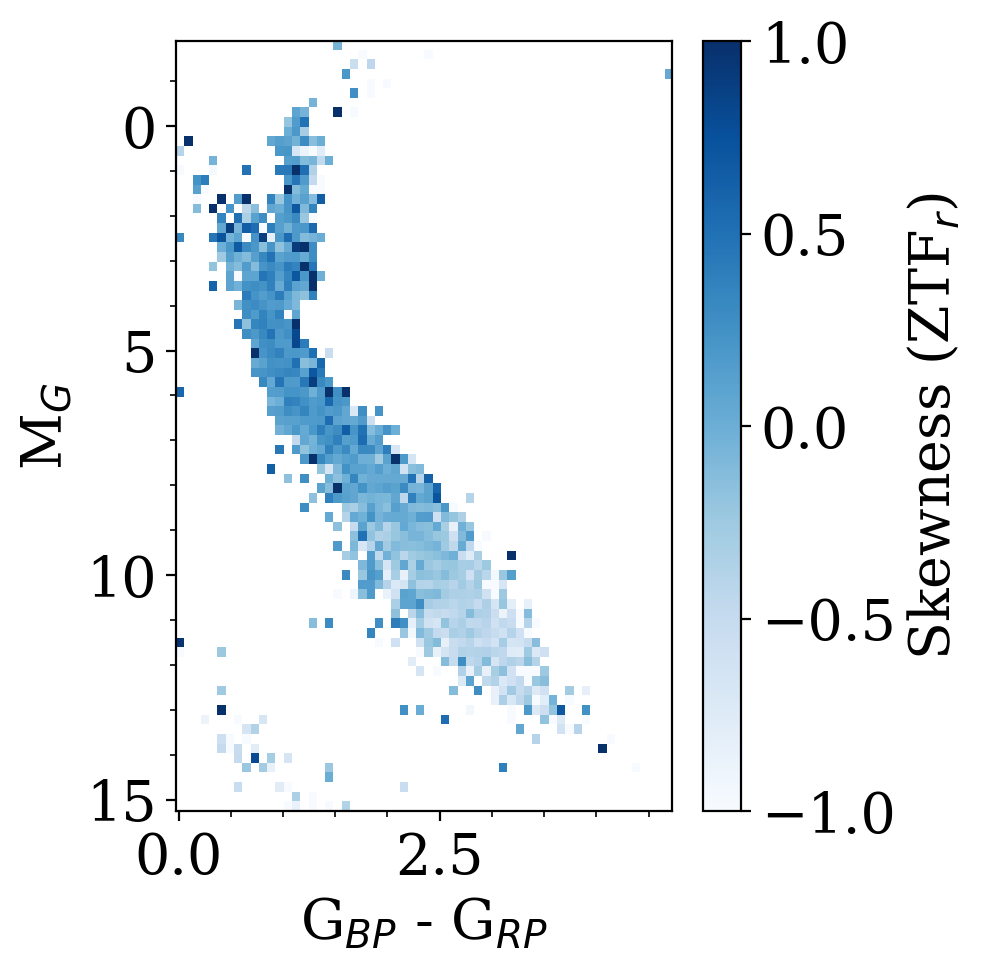

In [70]:
H = binned_statistic_2d(demo['bp_rp_gaia'], Mg, demo['skew_r'], bins=(60, 80))

plt.figure(figsize=(4,5))
plt.imshow(H[0].T, origin='lower', vmin=-1, vmax=1, cmap='Blues',
 extent=[min(H[1]),max(H[1]), min(H[2]), max(H[2])], 
 aspect='auto')
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])
plt.colorbar(label='Skewness (ZTF$_{r}$)')
plt.xlabel("G$_{BP}$ - G$_{RP}$")
plt.ylabel("M$_{G}$")

Text(0, 0.5, 'M$_{G}$')

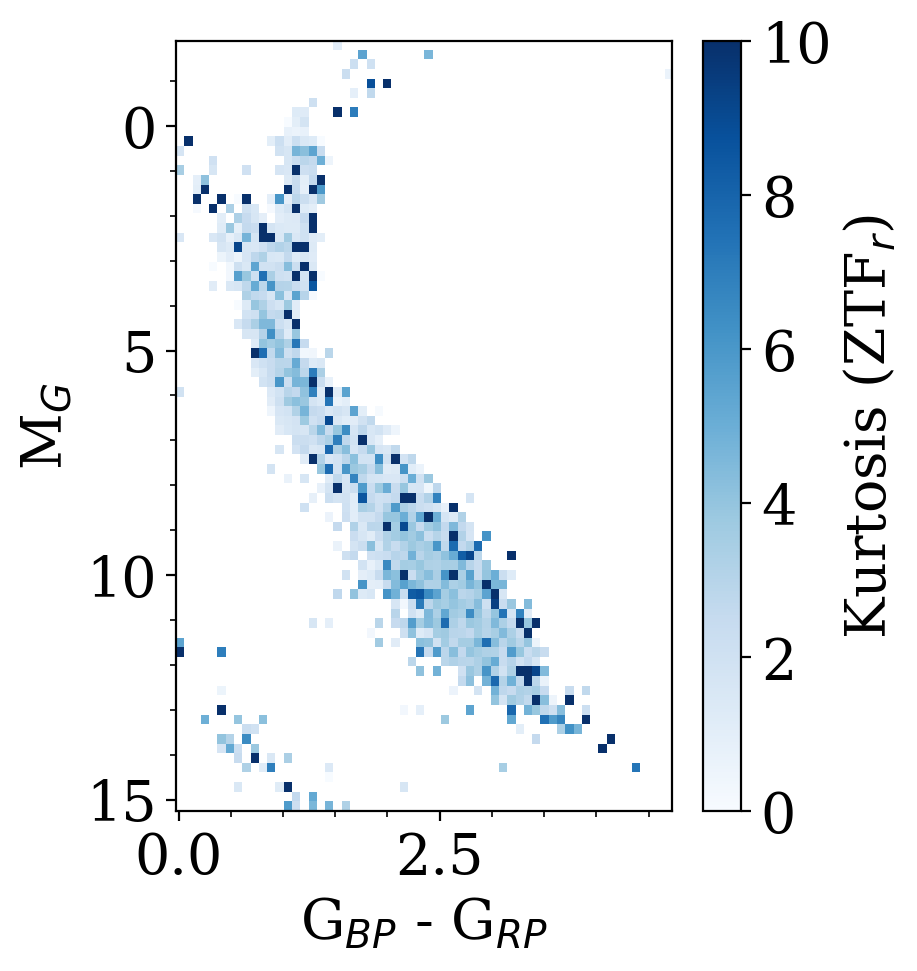

In [71]:
H = binned_statistic_2d(demo['bp_rp_gaia'], Mg, demo['kurtosis_r'], bins=(60, 80))

plt.figure(figsize=(4,5))
plt.imshow(H[0].T, origin='lower', vmin=0, vmax=10, cmap='Blues',
 extent=[min(H[1]),max(H[1]), min(H[2]), max(H[2])], 
 aspect='auto')
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])
plt.colorbar(label='Kurtosis (ZTF$_{r}$)')
plt.xlabel("G$_{BP}$ - G$_{RP}$")
plt.ylabel("M$_{G}$")

Text(0, 0.5, 'M$_{G}$')

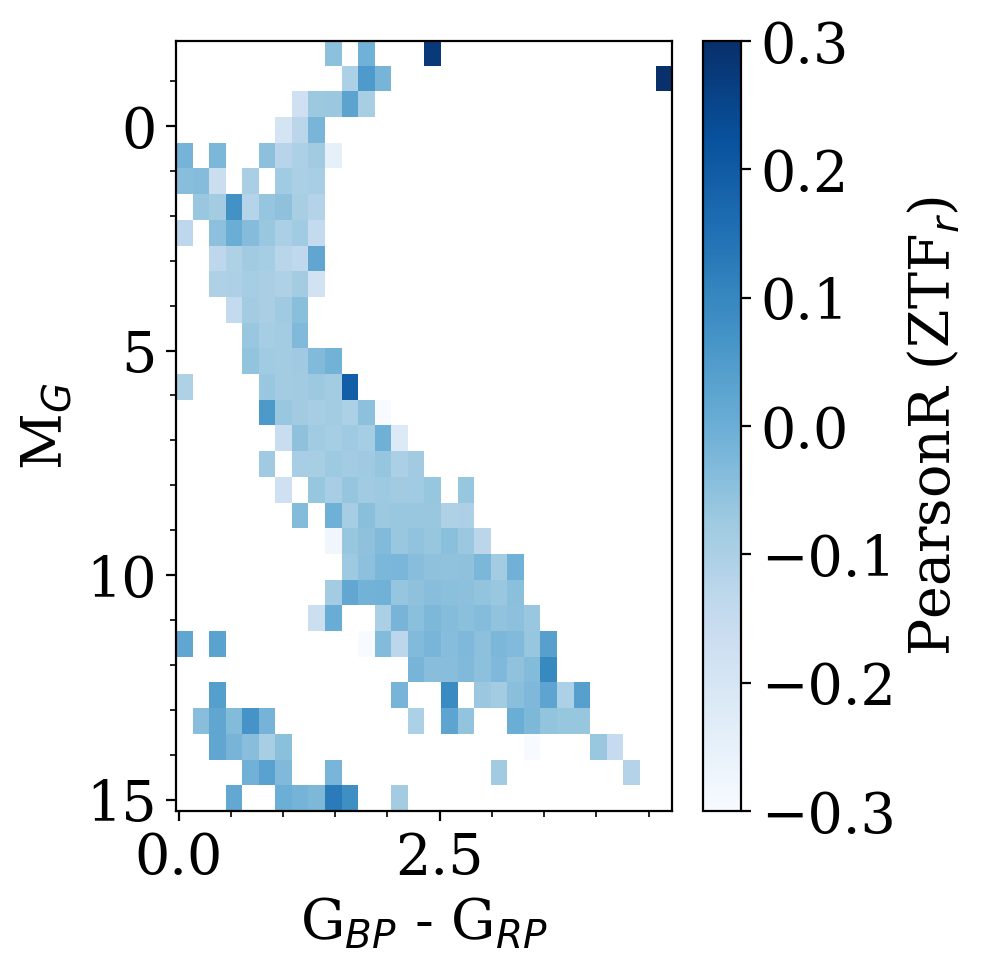

In [83]:
H = binned_statistic_2d(demo['bp_rp_gaia'], Mg, demo['rvalue_r'], bins=(30, 30))

plt.figure(figsize=(4,5))
plt.imshow(H[0].T, origin='lower', vmin=-0.3, vmax=0.3, cmap='Blues',
 extent=[min(H[1]),max(H[1]), min(H[2]), max(H[2])], 
 aspect='auto')
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])
plt.colorbar(label='PearsonR (ZTF$_{r}$)')
plt.xlabel("G$_{BP}$ - G$_{RP}$")
plt.ylabel("M$_{G}$")

### Plotting Light Curves

In [86]:
demo[demo['rvalue_r']>0.5].head(3).index

Index([45783762247614464, 45783758166556672, 5025368059863367680], dtype='uint64', name='_hipscat_index')

In [104]:
dm = ens.source.query("_hipscat_index==5025368059863367680")

In [105]:
%%time
lc = dm.compute() # only one minute :') 

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 58.4 s, sys: 40 s, total: 1min 38s
Wall time: 1min 34s


In [107]:
lc.head(1)

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5025368059863367680,1636148068921376768,Gaia DR3 2512683999919889536,2512683999919889536,1203869115,2016.0,28.509337,0.043322,3.666925,0.03507,1.851339,...,0,450,15.486078,0.011813,58765.33437,17,i,6,10000,17853


(16.386958510195836, 16.15543600958772)

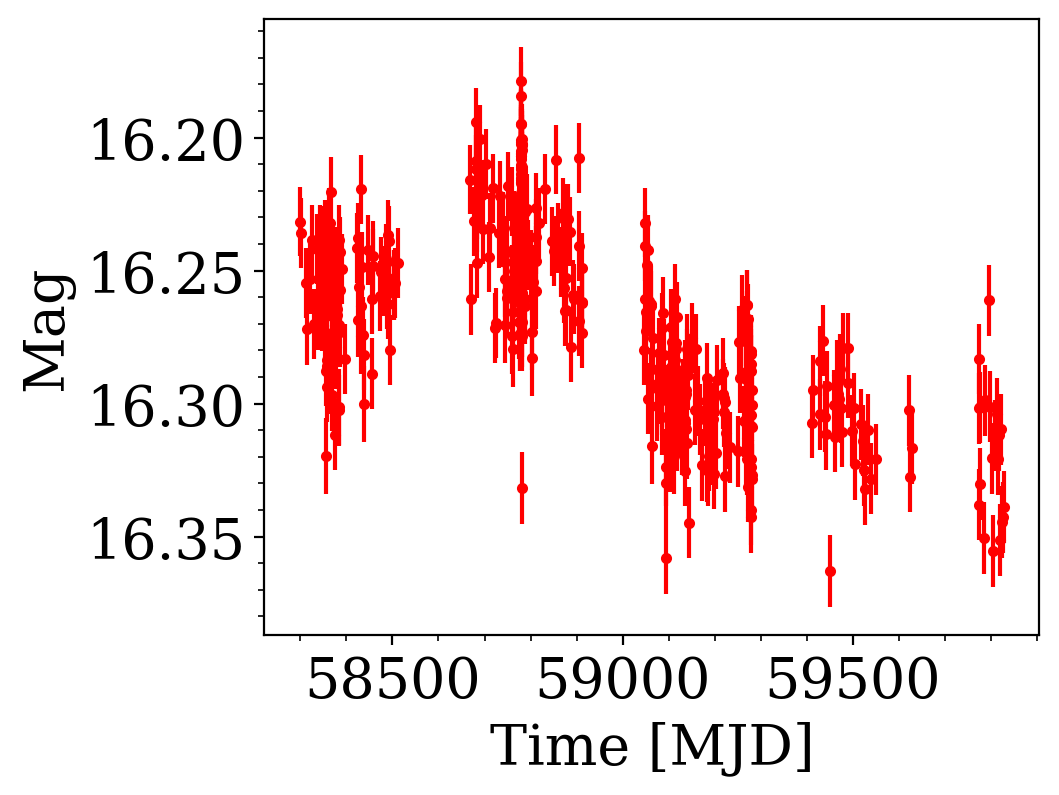

In [106]:
rband = (lc['band_ztf_source']=='r') & (lc['catflags_ztf_source']==0)

plt.figure(figsize=(5,4))
plt.errorbar(lc['mjd_ztf_source'][rband],
             lc['mag_ztf_source'][rband],
             yerr=lc['magerr_ztf_source'][rband],
             fmt='.', color='red')
plt.ylabel("Mag")
plt.xlabel("Time [MJD]")
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])
